In [1]:
import numpy as np
import math, os, pickle, inspect
import matplotlib.pyplot as plt
from numpy.lib.recfunctions import stack_arrays
%matplotlib inline


GNewton = 4.302113488372941e-06  # G in kpc * (km/s)**2 / Msun
fourpi = 4.0 * np.pi
age = 10.0 # Gyrs
gyr = 3.15576e+16
rate_const = 1.5278827817856099e-26 * age * gyr

script_dir = os.path.dirname(os.path.abspath(inspect.getframeinfo(inspect.currentframe()).filename))
saved_here = script_dir
# saved_here = os.path.join(script_dir, '..')

def unpickle(loc, sdir = None, test = True):
    if sdir: 
        fod = os.path.join(sdir,loc)
    else:
        fod = os.path.join(os.getcwd(),loc)
    if os.path.isfile(fod):
        reduced_data = pickle.load( open(fod,"rb") )
        reduced_data = reduced_data.view(np.recarray)
    else:
        files = [os.path.join(fod, f) for f in os.listdir(fod) if os.path.isfile(os.path.join(fod, f))]
        reduced_data = pickle.load( open(files[0],"rb") )
        for file in files[1:]:
            a = pickle.load( open(file,"rb") )
            reduced_data = stack_arrays((reduced_data,a), usemask=False, asrecarray=True)       
    if test:
        s = np.ravel(reduced_data.emcee.rho_r1*reduced_data.emcee.sigma0*reduced_data.emcee.cross*rate_const)
        print(np.median(s),np.std(s))
        ok = np.all([math.isclose(item, 1.0, rel_tol = 1e-2, abs_tol = 0.0) for item in s])
        print(ok)
    return reduced_data

reduced_data = unpickle('sparc_cross_3_reg_sqrt2_c200p_rate_1e5.txt', sdir = saved_here)
reduced_data_1 = unpickle('sparc_cross_3_constrained_halo.txt', sdir = saved_here)
reduced_data_2 = unpickle('sparc_cross_3_c200p_rate_1e5_ml_katz_inc_geq_30_no_vflat_Q_lt_3.txt', sdir = saved_here)
reduced_data_3 = unpickle('sparc_cross_3_c200p_rate_1e5_ml_katz_NGC2903.txt', sdir = saved_here)
reduced_data_4 = unpickle('sparc_cross_3_c200p_rate_1e5_ml_katz_NGC4217.txt', sdir = saved_here)
reduced_data_mond = unpickle('sparc_mond_a0_12e-11_katz_etal.txt', sdir = saved_here, test=False)
print(len(reduced_data)+len(reduced_data_2)+2)
print(len(reduced_data_1))
ndata_max = max([len(item.Data.R) for item in reduced_data]+\
               [len(item.Data.R) for item in reduced_data_2]+\
               [len(item.Data.R) for item in reduced_data_3]+\
               [len(item.Data.R) for item in reduced_data_4])
print(ndata_max)
print(reduced_data.dtype)

1.0 6.276775220574117e-17
True
1.0 1.7644633557471385e-13
True
1.0 6.280652897909965e-17
True
1.0 6.354754052983605e-17
True
1.0 6.216877200328398e-17
True
163
122
115
(numpy.record, [('Galaxy', '<U99'), ('T', '<i8'), ('D', '<f8'), ('e_D', '<f8'), ('f_D', '<i8'), ('Inc', '<f8'), ('e_Inc', '<f8'), ('Lum', '<f8'), ('e_Lum', '<f8'), ('Reff', '<f8'), ('SBeff', '<f8'), ('Rdisk', '<f8'), ('SBdisk', '<f8'), ('MHI', '<f8'), ('RHI', '<f8'), ('Vflat', '<f8'), ('e_Vflat', '<f8'), ('Q', '<i8'), ('Ref', 'O'), ('Vb_peak', '<f8'), ('Vb_peak_location', '<f8'), ('ML_maxdisk', '<f8'), ('ML_maxbulge', '<f8'), ('Angmom', 'O'), ('Angmom_int', '<f8'), ('Data', [('Filename', '<U200'), ('R', 'O'), ('R_min', '<f8'), ('R_max', '<f8'), ('V', 'O'), ('e_V', 'O'), ('Gas', 'O'), ('Disk', 'O'), ('Bulge', 'O')]), ('Regr', [('Vmax', '<f8'), ('Rmax', '<f8'), ('chi2', '<f8'), ('V', '<f8', (9,)), ('dV', '<f8', (9,)), ('ddV', '<f8', (9,)), ('V_data', 'O'), ('Vdm_med', 'O'), ('Vdm_max', 'O'), ('Vdm_min', 'O'), ('V_spline', 

In [106]:
from scipy.interpolate import griddata
from SIDMmodel1 import match_nfw
from SIDMmodel1 import abundance_match_behroozi_2012 as am

def add_field(a, descr):
    if a.dtype.fields is None:
        print("`A' must be a structured numpy array")
        raise
    b = np.empty(a.shape, dtype=a.dtype.descr + descr )
    for name in a.dtype.names:
        b[name] = a[name]
    return b

def remove_field_name(a, name):
    names = list(a.dtype.names)
    if name in names:
        names.remove(name)
    b = a[names]
    return b

def add_value(reduced_data, nhalo_params=2, ml_disk_min=0, ml_disk_max=1e30):
    nsamples = len(reduced_data[0].emcee.ml_disk)
    ndim = len(reduced_data[0].emcee.samples[0])
    reduced_data_2 = add_field(reduced_data, 
                           [('newvar', float, (nsamples,)),\
                            ('v_max', float, (nsamples,)),\
                            ('r_max', float, (nsamples,)),\
                            ('red_chisq', float, (nsamples,)),\
                            ('m_star', float, (nsamples,)),\
                            ('m_baryons', float, (nsamples,)),\
                            ('min_red_chisq', float),\
                            ('min_red_chisq_params', float, (ndim,)),
                            ('min_red_chisq_v_sm', float, (ndata_max,)),
                            ('min_red_chisq_v_m', float, (ndata_max,)),
                            ('min_red_chisq_a_sm', float, (ndata_max,)),
                            ('min_red_chisq_a_m', float, (ndata_max,)),
#                             ('contour', float, object),
                            ])
    reduced_data_2 = reduced_data_2.view(np.recarray)
    
    for item in reduced_data_2:
        has_bulge = False if sum(item.Data.Bulge) == 0 else True
        Rlast = item.Data.R[-1]
        m_bulge = np.array([v_b[-1]**2 * Rlast / 4.302e-6 for v_b in item.emcee.v_b])
        L_disk = item.Lum-m_bulge/(item.emcee.ml_bulge*1e9) if has_bulge else item.Lum
        item.m_star = item.emcee.ml_disk*L_disk*1e9 + m_bulge
        item.m_baryons = item.m_star + item.MHI*1e9
        item.newvar = item.m_baryons/(50*item.Vflat**4)
        ndata = len(item.Data.R)
        nv = ndata - (2 if has_bulge else 1) - nhalo_params
        item.red_chisq = item.emcee.chisq/nv 
        red_chisq = np.array([a/nv for (a,b) in \
                              zip(item.emcee.chisq,item.emcee.ml_disk) if \
                              ml_disk_min<b<ml_disk_max])
        i = np.argmin(red_chisq)
        item.min_red_chisq = red_chisq[i]
        item.min_red_chisq_params = [a for (a,b) in \
                            zip(item.emcee.samples,item.emcee.ml_disk) if \
                            ml_disk_min<b<ml_disk_max][i]
        item.min_red_chisq_v_sm[:ndata] = np.array([a for (a,b) in \
                            zip(item.emcee.v_sm,item.emcee.ml_disk) if \
                            ml_disk_min<b<ml_disk_max])[i]
        item.min_red_chisq_v_m[:ndata] = np.array([a for (a,b) in \
                            zip(item.emcee.v_m,item.emcee.ml_disk) if \
                            ml_disk_min<b<ml_disk_max])[i]
        item.min_red_chisq_a_sm[:ndata] = item.min_red_chisq_v_sm[:ndata]**2/item.Data.R
        item.min_red_chisq_a_m[:ndata] = item.min_red_chisq_v_m[:ndata]**2/item.Data.R
#         item.v_max, item.r_max = get_vmax_rmax_nfw(item, item.emcee.ml_disk, \
#                                             item.emcee.ml_bulge, item.emcee.r1, \
#                                             item.emcee.mass_r1, item.emcee.rho_r1, \
#                                             item.emcee.rmax, item.emcee.vmax) 
    return reduced_data_2
    

nc = 30
def contours(x_in, y_in, z_in, xlo, xhi, ax=None):
    x = np.ma.masked_invalid(x_in)
    x1 = np.ma.masked_outside(x_in, xlo, xhi)
    mask = np.ma.mask_or(x.mask, x1.mask)
    y = np.ma.masked_invalid(y_in)
    mask = np.ma.mask_or(mask, y.mask)
    if np.ma.all(mask):
        return -1
    x = np.ma.compressed(np.ma.array(x_in, mask = mask))
    y = np.ma.compressed(np.ma.array(y_in, mask = mask))
    z = np.ma.compressed(np.ma.array(z_in, mask = mask))
    xmin, xmax = np.percentile(x, [1, 99],axis=0)
    ymin, ymax = np.percentile(y, [1, 99],axis=0)
#     print(xmin, xmax, ymin, ymax)
    xi = np.linspace(xmin,xmax,nc)
    yi = np.linspace(ymin,ymax,nc)
    dx, dy = xi[1]-xi[0], yi[1]-yi[0]
    zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')
    zmin = np.amin(z)
    z_c = np.percentile(z, 68, axis=0)
    z_c = min( zmin+2.3, z_c )
#     cs = measure.find_contours(zi, z_c)
    if ax:
        xi, yi = np.mgrid[xmin:xmax:30j, ymin:ymax:30j]
        zi = griddata((x, y), z, (xi, yi), method='cubic')
        ax.contour(xi,yi,zi,[z_c],linewidths=2)
#         for n, contour in enumerate(cs):
#             ax.plot(xmin+dx*contour[:, 1], ymin+dy*contour[:, 0], linewidth=2)

    return 1

mn = match_nfw()
def conc_prior(m200,c200):
    return True if np.abs(np.log10(c200/mn.dutton_c200(m200))) < 0.05 else False

def am_prior(mstar,m200):
    return True if np.abs(np.log10(mstar/am(m200))) < 0.05 else False

def vmax_prior(vmax, vflat):
    return True if np.abs(np.log10(vmax/vflat)) < 0.05 else False
    

def get_min_likelihood_values(data,ml_lo,ml_hi,\
                              model_name='sidm',\
                              conc_prior_flag=False,\
                              am_prior_flag=False,\
                             vmax_prior_flag=False,\
                             keep_bulges=True):
    like = []
    bic = []
    dof = []
    removed = []
    slope = []
    if model_name == 'sidm':
        param_names = ['rho0','sigma0','cross','ml_disk','ml_bulge']
        nhalo_params = 2
    elif model_name == 'sidm1p':
        param_names = ['rho0','sigma0','cross','ml_disk','ml_bulge']
        nhalo_params = 0
    elif model_name == 'mond':
        param_names = ['a0','ml_disk', 'ml_bulge']
        nhalo_params = 0
    else:
        print("model not implemented in this code")
        exit()
    for galaxy in data:
        ndata = len(galaxy.Data.R)
        if sum(galaxy.Data.Bulge) > 0:
            has_bulge = True
            npar = nhalo_params+2
            mask = [True if ml_lo<=mldisk<=ml_hi and \
                    ml_lo<=mlbulge<=ml_hi else False for mldisk,mlbulge \
                    in zip(galaxy.emcee.ml_disk,galaxy.emcee.ml_bulge)]
        else:
            has_bulge = False            
            npar = nhalo_params+1
            mask = [True if ml_lo<=mldisk<=ml_hi else False for \
                    mldisk in galaxy.emcee.ml_disk]
        if conc_prior_flag:
            mask = [m and conc_prior(m200,c200) for m,m200,c200 \
                in zip(mask,galaxy.emcee.mvir,galaxy.emcee.cvir)]
        if am_prior_flag:
            mask = [m and am_prior(mldisk*galaxy.Lum*1e9,m200) for m,mldisk,m200 \
                   in zip(mask,galaxy.emcee.ml_disk,galaxy.emcee.mvir)]
        if vmax_prior_flag:
            mask = [m and vmax_prior(vmax,max(galaxy.Vflat,0.1)) for m,vmax \
                in zip(mask,galaxy.emcee.vmax)]
        if ndata > 4 and galaxy.Q != 3 and galaxy.Inc >= 30 and ((has_bulge and keep_bulges) or (not has_bulge)):
            cvals = galaxy.emcee.chisq[mask]
#             print(len(cvals),len(galaxy.emcee.chisq))
            if len(cvals) > 0:
                dof_val = ndata - npar
                minc = min(cvals)
                like.append([galaxy.Galaxy,minc/dof_val])
                bic.append([galaxy.Galaxy,minc+npar*np.log(ndata)])
                dof.append([galaxy.Galaxy,dof_val])
                slope_val = np.median(galaxy.emcee.slope_15pRvir[mask]) if nhalo_params > 0 else 0
                mldisk = np.median(galaxy.emcee.ml_disk[mask])
                mstar = mldisk*galaxy.Lum*1e9
                m200 = np.median(galaxy.emcee.mvir[mask]) if nhalo_params > 0 else 1
                mbary = mstar + galaxy.MHI*1e9
                vmax = np.median(galaxy.emcee.vmax[mask]) if nhalo_params > 0 else 0
                slope.append([mstar/(np.pi*galaxy.Rdisk**2),slope_val,mldisk,mstar,galaxy.Rdisk,vmax,m200])
            else:
                print(galaxy.Galaxy,galaxy.Q,\
                      np.median(galaxy.emcee.ml_disk),np.std(galaxy.emcee.ml_disk),\
                     np.median(galaxy.emcee.ml_bulge),np.std(galaxy.emcee.ml_bulge))
                removed.append(galaxy.Galaxy)
    return like, bic, dof, removed, slope


def get_dic_values(data,ml_lo,ml_hi,model_name='sidm',alt=False,posterior_max=False,checks=False,keep_bulges=True):
    from SPARCdata import dt
    from SIDMmodel1 import lnlike,sidm_setup,match_nfw
    from SIDMmodel_cm_am import lnlike_constrained, constrained_sidm_profile
    from mond import mond
    emcee_params = 5, 40, 400, 2000, 5, 1
    __, dt_blobs = dt(emcee_params, [])
    ss = sidm_setup()
    mn = match_nfw()
    mn1 = mond()
    pd = []
    dic = []
    removed = []
    if model_name == 'sidm':
        param_names = ['rho0','sigma0','cross','ml_disk','ml_bulge']
        nhalo_params = 2
    elif model_name == 'sidm1p':
        param_names = ['rho0','sigma0','cross','ml_disk','ml_bulge']
        nhalo_params = 0
    elif model_name == 'mond':
        param_names = ['a0','ml_disk', 'ml_bulge']
        nhalo_params = 0
    else:
        print("model not implemented in this code")
        exit()
    for galaxy in data:
        ndata = len(galaxy.Data.R)
        if sum(galaxy.Data.Bulge) > 0:
            has_bulge = True
            npar = nhalo_params+2
            mask = [True if ml_lo<=mldisk<=ml_hi and \
                    ml_lo<=mlbulge<=ml_hi else False for mldisk,mlbulge \
                    in zip(galaxy.emcee.ml_disk,galaxy.emcee.ml_bulge)]
        else:
            has_bulge = False
            npar = nhalo_params+1
            mask = [True if ml_lo<=mldisk<=ml_hi else False for \
                    mldisk in galaxy.emcee.ml_disk]
        ndof = ndata-npar
        if ndata > 4 and galaxy.Q != 3 and galaxy.Inc >= 30 and ((has_bulge and keep_bulges) or (not has_bulge)):
            cvals = galaxy.emcee.chisq[mask]
            if len(cvals) > 0:
                ac = np.median(cvals) #np.average(cvals)
                sc = np.std(cvals)
                pos = np.argmax(galaxy.emcee.lnprob[mask])
                pos_max_params = [galaxy.emcee[name][mask][pos] for name in param_names]
                med_params = [np.median(galaxy.emcee[name][mask]) for name in param_names]
                std_params = [np.std(galaxy.emcee[name][mask]) for name in param_names]
                if checks: print("Galaxy : ",galaxy.Galaxy)
                if posterior_max:
                    ave_params = pos_max_params
                    ca = galaxy.emcee.chisq[mask][pos]
                    if checks: print("chisq at posterior max : ",ca)
                else:
                    ave_params = med_params
                    if model_name == 'sidm' or model_name == 'sidm1p':
                        prior_params, reg_params, bounds = get_priors_bounds(galaxy)
                        args = galaxy, ss, mn, emcee_params, prior_params, reg_params, bounds 
                        lnl, bb = lnlike(ave_params, args)
                        out = tuple(ave_params) + bb
                        out = np.array(out, dtype=dt_blobs)
                        ca = out['chisq']
                    elif model_name == 'sidm1p':
                        csp = constrained_sidm_profile('planck13',3.0,10.0,galaxy)
                        emcee_params = 5, 10, 10, 20, 1, 1 
                        prior_params, reg_params, bounds = get_priors_bounds(galaxy)
                        args = galaxy, ss, csp, emcee_params, prior_params, reg_params, bounds
                        lnl, bb = lnlike_constrained(params,args)
                        out = np.array(bb, dtype=dt_blobs)
                        ca = out['chisq']
                    elif model_name == 'mond':
                        ca = get_mond_chisq(ave_params,galaxy,mn1)
                    else:
                        print("model not implemented in this code")
                        exit()
                    if checks: print("chisq at median param values: ",ca)
                if checks: print("median param values : ",ave_params)
                if checks: print("std dev param values : ",std_params)
                if checks: print("param values at posterior max : ",ave_params)
                if checks: print("average chisq: ",ac, "min chisq: ",min(cvals), "dof: ",ndof)
                pd_val = sc if alt else ac-ca 
                pd.append([galaxy.Galaxy,2*pd_val/np.log(ndata),np.std(galaxy.emcee.ml_disk),np.median(galaxy.emcee.ml_disk)])
                dic.append([galaxy.Galaxy,ca+2*pd_val])
            else:
                print(galaxy.Galaxy,galaxy.Q,\
                      np.median(galaxy.emcee.ml_disk),np.std(galaxy.emcee.ml_disk),\
                     np.median(galaxy.emcee.ml_bulge),np.std(galaxy.emcee.ml_bulge))
                removed.append(galaxy.Galaxy)
    return dic, pd, removed 


def get_priors_bounds(galaxy): 
    rmax_prior = False
    bulge_prior = False # enforces ml_bulge > ml_disk with strictness defined by bulge_prior_width
    bulge_prior_width = 0.05 # in ml_bulge-ml_disk
    log10rmax_spread = 0.11
    log10c200_spread = 0.11
    if sum(galaxy.Data.Bulge) > 0:
        tophat_prior = True
        tophat_width = 3
    else:
        tophat_prior = True
        tophat_width = 3
# cosmo and ml prior parameters: 
# (rmax_prior = True or False; if False use c200;
# rmax at 100 km/s in kpc, \
# slope = dlog(rmax)/dlog(vmax), \
# spread in P(log10(rmax)|vmax), \ 
# spread in P(log10(c200)|m200); only use if rmax_prior = False,\
# tophat_prior = True or False; if False then log-normal, \
# half_width in units of spread for tophat prior, \
# ml_median for disk, log10ml_spread, \
# bulge_prior = True or False; if True ML_bulge>ML_disk)
    ml_median = 0.5 # if ml_median < 0, then impose AM
    log10ml_spread = 100
    prior_params = (rmax_prior, 27, 1.4, log10rmax_spread,\
                    log10c200_spread, tophat_prior, tophat_width,\
                    ml_median, log10ml_spread, bulge_prior, bulge_prior_width)
    if galaxy.Vflat > 0: 
        vmax_prior = True
        abs_e_v = 0.05*galaxy.Vflat
    else:
        vmax_prior = False
        abs_e_v = 0.05*((0.5*galaxy.Lum+galaxy.MHI)*1e9/50)**0.25        
    reg_params = (abs_e_v, 0.0, vmax_prior, 1.414)
# log10(ss.rate_const * cross * rho0 * sigma0), log10(sigma0), \
# log10(cross/(cm^2/g)), ml_disk, ml_bulge   
    bounds = [(np.log10(2),np.log10(1e5)),\
              (np.log10(2),np.log10(500)),\
              (np.log10(3),np.log10(3)),\
              (0.3,0.8),\
              (0.3,0.8)]
# Ren et al ML prior was 0.1 to 10
# Katz et al ML prior was 0.3 to 0.8
    return prior_params, reg_params, bounds

def get_mond_chisq(params,galaxy,mn):
    a0_in, ml_disk, ml_bulge = params
    a0 = 3.08567758e13 * a0_in # convert from m/s**2 to (km/s)**2/kpc
    v_b = np.sqrt(ml_bulge)*galaxy.Data.Bulge
    v_d = np.sqrt(ml_disk)*galaxy.Data.Disk
    v2_baryons = galaxy.Data.Gas ** 2 + v_d ** 2 + v_b ** 2        
    g_baryons = v2_baryons / galaxy.Data.R 
    v_baryons = np.sqrt(v2_baryons)
    v2_m = mn.v2mond(g_baryons/a0) * v2_baryons
    v_m = np.sqrt(v2_m)
    v_dm = np.sqrt( v2_m - v2_baryons )
    chisq = np.sum( (galaxy.Data.V - v_m) ** 2 / galaxy.Data.e_V ** 2 )
    return chisq


In [53]:
from iteration_utilities import duplicates
write_like = False
cp = False
ap = False
vp = False
bulges = True
ml_lo = 0.1
ml_hi = 10
if ml_lo == 0.1 and ml_hi == 10: add34 = False
like0 = get_min_likelihood_values(reduced_data,ml_lo,ml_hi,\
                      conc_prior_flag=cp,am_prior_flag=ap,vmax_prior_flag=vp,keep_bulges=bulges)
like1 = get_min_likelihood_values(reduced_data_1,0.1,10,model_name='sidm1p',keep_bulges=bulges)
like2 = get_min_likelihood_values(reduced_data_2,ml_lo,ml_hi,\
                      conc_prior_flag=cp,am_prior_flag=ap,vmax_prior_flag=vp,keep_bulges=bulges)
like3 = get_min_likelihood_values(reduced_data_3,ml_lo,ml_hi,\
                      conc_prior_flag=cp,am_prior_flag=ap,vmax_prior_flag=vp,keep_bulges=bulges)
like4 = get_min_likelihood_values(reduced_data_4,ml_lo,ml_hi,\
                      conc_prior_flag=cp,am_prior_flag=ap,vmax_prior_flag=vp,keep_bulges=bulges)
likem = get_min_likelihood_values(reduced_data_mond,0.1,10,model_name='mond',keep_bulges=bulges)
if add34:
    like = like0[0]+like2[0]+like3[0]+like4[0]
    bic = like0[1]+like2[1]+like3[1]+like4[1]
    dof = like0[2]+like2[2]+like3[2]+like4[2]
    slope = like0[4]+like2[4]+like3[4]+like4[4]
else:
    like = like0[0]+like2[0]
    bic = like0[1]+like2[1]
    dof = like0[2]+like2[2]
    slope = like0[4]+like2[4]
like_sidm1p = like1[0]
bic_sidm1p = like1[1]
slope_sidm1p = like1[4]
like_mond = likem[0]
bic_mond = likem[1]
print("removed: ",like0[3],like1[3],like2[3],like3[3],like4[3])
print(len(like),len(like_mond))
print('duplicates',list(duplicates(np.array(like)[:,0])))

def remove_not_common_and_sort(x_list,y_list):
    not_common = set([item[0] for item in x_list[0]]) ^ set([item[0] for item in y_list[0]])
    print(not_common)
    lx = len(x_list)
    ly = len(y_list)
    for item in not_common:
        try:
            irem = list(np.array(x_list[0])[:,0]).index(item)
            for i in range(lx): x_list[i].pop(irem)
        except:
            irem = list(np.array(y_list[0])[:,0]).index(item)
            for i in range(ly): y_list[i].pop(irem)
    for i in range(lx): x_list[i].sort()
    for i in range(ly): y_list[i].sort()
    return 0
                
remove_not_common_and_sort([like_sidm1p,bic_sidm1p,slope_sidm1p],[like_mond,bic_mond])
print(len(like_sidm1p),len(like_mond))
remove_not_common_and_sort([like,bic,dof,slope],[like_mond,bic_mond])
print(len(like),len(like_mond))
print(len(bic),len(bic_mond))

if write_like:
    file1 = open("a.txt","w") 
    file1.write('#SPARC Q<3 and Inc>=30 deg and (number of data points)>4.\n')
    file1.write('#Ren et al runs postprocessed with 0.3<M/L<0.8.\n')
    file1.write('#Galaxies not in Ren et al run with 0.3<M/L<0.\n')
    file1.write('#For those without Vflat, no Vmax regularization.\n')
    file1.write('#Two more galaxies than Katz et al because Katz et al\n')
    file1.write('#\t used an earlier version of SPARC that had two less\n')
    file1.write('#\t galaxies (according to Federico Lelli).\n')
    file1.write('# Columns are Galaxy name and Chisq/DOF where Chisq\n')
    file1.write('#\t is computed using the SPARC rotation velocity errors.\n')
    for item in list(like):
        file1.write(item[0])
        file1.write(', ')
        file1.write(str(item[1]))
        file1.write('\n')
    file1.close()

removed:  [] [] [] [] []
150 149
duplicates []
{'UGC02885', 'UGC05253', 'NGC7814', 'UGC11914', 'NGC5033', 'NGC2841', 'UGC06787', 'NGC4013', 'UGC02916', 'UGC03580', 'NGC4217', 'NGC7331', 'NGC2683', 'NGC6195', 'NGC0891', 'UGC02953', 'NGC2955', 'UGC09133', 'NGC5985', 'NGC6674', 'UGC02487', 'UGC06614', 'NGC4138', 'NGC5005', 'UGC06786', 'NGC4157', 'UGC03205', 'IC4202', 'UGC03546', 'NGC6946', 'UGC08699'}
118 118
{'UGC02885', 'UGC05253', 'NGC7814', 'UGC11914', 'UGC09133', 'NGC5033', 'NGC5985', 'NGC2841', 'UGC06787', 'NGC4013', 'NGC6674', 'UGC02487', 'UGC06614', 'NGC4138', 'NGC5005', 'UGC02916', 'UGC03580', 'NGC4217', 'UGC06786', 'NGC4157', 'UGC03205', 'IC4202', 'NGC7331', 'UGC06973', 'NGC2683', 'NGC6195', 'UGC03546', 'NGC0891', 'UGC02953', 'NGC6946', 'NGC2955', 'UGC08699'}
118 118
118 118


In [109]:
pmax = True
alt = False
sidm1p = False

dic0,pd0,removed0 = get_dic_values(reduced_data,ml_lo,ml_hi,posterior_max=pmax,alt=alt,keep_bulges=bulges)
dic_sidm1p,pd_sidm1p,removed_sidm1p = \
get_dic_values(reduced_data_1,ml_lo,ml_hi,model_name='sidm1p',posterior_max=pmax,alt=alt,keep_bulges=bulges,checks=True)
dic2,pd2,removed2 = get_dic_values(reduced_data_2,ml_lo,ml_hi,posterior_max=pmax,alt=alt,keep_bulges=bulges)
dic3,pd4,removed3 = get_dic_values(reduced_data_3,ml_lo,ml_hi,posterior_max=pmax,alt=alt,keep_bulges=bulges)
dic4,pd4,removed4 = get_dic_values(reduced_data_4,ml_lo,ml_hi,posterior_max=pmax,alt=alt,keep_bulges=bulges)
dic_mond,pd_mond,removed_mond = \
get_dic_values(reduced_data_mond,ml_lo,ml_hi,model_name='mond',posterior_max=pmax,alt=alt,keep_bulges=bulges,checks=True)

if sidm1p:
    dic_mond = dic_sidm1p
    pd_mond = pd_sidm1p
    removed_mond = removed_sidm1p

if add34:
    dic = dic0 + dic2 + dic3 + dic4
    pd = pd0 + pd2 + pd3 + pd4
    removed = removed0 + removed2 + removed3 + removed4
else:
    dic = dic0 + dic2
    pd = pd0 + pd2
    removed = removed0 + removed2



Galaxy :  CamB
chisq at posterior max :  371.8654464560204
median param values :  [44900210.53652651, 20.39262836588174, 3.0, 0.1000285261326254, 10.0]
std dev param values :  [590197.2176166113, 0.6834950412732238, 0.0, 0.020106756354777044, 0.0]
param values at posterior max :  [44900210.53652651, 20.39262836588174, 3.0, 0.1000285261326254, 10.0]
average chisq:  387.0748584602952 min chisq:  371.8654464560204 dof:  8
Galaxy :  D564-8
chisq at posterior max :  45.14458761279304
median param values :  [46759152.24247272, 16.735690102832216, 3.0, 0.10006795420508657, 10.0]
std dev param values :  [1447804.5584626126, 0.8822103954922281, 0.0, 0.03215698556391396, 0.0]
param values at posterior max :  [46759152.24247272, 16.735690102832216, 3.0, 0.10006795420508657, 10.0]
average chisq:  56.13393975900661 min chisq:  45.14458761279304 dof:  5
Galaxy :  D631-7
chisq at posterior max :  133.05369634110437
median param values :  [35953560.04461005, 34.29312175920004, 3.0, 0.27491513974599857

Galaxy :  NGC2915
chisq at posterior max :  112.53136403315774
median param values :  [2205455225.6355734, 50.05842291023722, 3.0, 0.5746573475192509, 10.0]
std dev param values :  [269756258.01630676, 0.614369802818463, 0.0, 0.030958726112434283, 0.0]
param values at posterior max :  [2205455225.6355734, 50.05842291023722, 3.0, 0.5746573475192509, 10.0]
average chisq:  118.1835896872915 min chisq:  112.53136403315774 dof:  29
Galaxy :  NGC2976
chisq at posterior max :  10.096507394940131
median param values :  [92770325.12892443, 65.23689603848739, 3.0, 0.4847816692294615, 10.0]
std dev param values :  [8860542.10217432, 1.1167404549280557, 0.0, 0.04554091582844634, 0.0]
param values at posterior max :  [92770325.12892443, 65.23689603848739, 3.0, 0.4847816692294615, 10.0]
average chisq:  18.355362356310202 min chisq:  10.014912323530371 dof:  26
Galaxy :  NGC2998
chisq at posterior max :  212.4198034647407
median param values :  [38121884.91230484, 159.70417002235774, 3.0, 0.343745239

average chisq:  59.6985419769726 min chisq:  55.46779854087918 dof:  45
Galaxy :  UGC00128
chisq at posterior max :  170.347605130454
median param values :  [18667621.89219289, 82.41012846995311, 3.0, 0.685101671932524, 10.0]
std dev param values :  [300335.3092634065, 2.2296000706510526, 0.0, 0.0739292855172603, 0.0]
param values at posterior max :  [18667621.89219289, 82.41012846995311, 3.0, 0.685101671932524, 10.0]
average chisq:  211.774163325847 min chisq:  120.56957813870187 dof:  21
Galaxy :  UGC00191
chisq at posterior max :  683.7203542556865
median param values :  [29268365.64852027, 68.33467983240638, 3.0, 0.8997614696586326, 10.0]
std dev param values :  [3083408.492473718, 2.132409842077077, 0.0, 0.16222509958465728, 0.0]
param values at posterior max :  [29268365.64852027, 68.33467983240638, 3.0, 0.8997614696586326, 10.0]
average chisq:  729.9718665273041 min chisq:  417.5446189448609 dof:  8
Galaxy :  UGC00731
chisq at posterior max :  72.34802571589776
median param valu

Galaxy :  UGC07577
chisq at posterior max :  67.4475552819387
median param values :  [39968640.252942905, 18.324958972395702, 3.0, 0.10042764014824106, 10.0]
std dev param values :  [541975.8632473103, 1.1202614748290827, 0.0, 0.04007440374366937, 0.0]
param values at posterior max :  [39968640.252942905, 18.324958972395702, 3.0, 0.10042764014824106, 10.0]
average chisq:  78.86665611351017 min chisq:  67.4475552819387 dof:  8
Galaxy :  UGC07603
chisq at posterior max :  9.50768819907132
median param values :  [73885397.33548853, 51.41946490758483, 3.0, 1.1146577818104442, 10.0]
std dev param values :  [8492347.44047247, 1.6265435001827375, 0.0, 0.17593905756275738, 0.0]
param values at posterior max :  [73885397.33548853, 51.41946490758483, 3.0, 1.1146577818104442, 10.0]
average chisq:  13.050248915847131 min chisq:  9.50768819907132 dof:  11
Galaxy :  UGC07690
chisq at posterior max :  6.547162106379504
median param values :  [3538225495.9033637, 79.9412092246079, 3.0, 1.4590650078000

Galaxy :  DDO168
chisq at posterior max :  185.99500134806416
median param values :  [1.2000000000000008e-10, 0.10000023004568372, 0.1]
std dev param values :  [2.5849394142282115e-26, 0.015616872982674213, 2.7755575615628914e-17]
param values at posterior max :  [1.2000000000000008e-10, 0.10000023004568372, 0.1]
average chisq:  187.77300243416158 min chisq:  185.99500134806416 dof:  9
Galaxy :  DDO170
chisq at posterior max :  759.4134761848284
median param values :  [1.2000000000000008e-10, 0.10000007658976545, 0.1]
std dev param values :  [2.5849394142282115e-26, 0.0037656405190380346, 2.7755575615628914e-17]
param values at posterior max :  [1.2000000000000008e-10, 0.10000007658976545, 0.1]
average chisq:  761.424081373859 min chisq:  759.4134761848284 dof:  7
Galaxy :  ESO079-G014
chisq at posterior max :  45.181689473776316
median param values :  [1.2000000000000008e-10, 0.602650797907781, 0.1]
std dev param values :  [2.5849394142282115e-26, 0.017618369125015184, 2.7755575615628

Galaxy :  NGC0891
chisq at posterior max :  127.82175348182218
median param values :  [1.2000000000000008e-10, 0.42197761817965507, 0.41704038031220225]
std dev param values :  [2.5849394142282115e-26, 0.012815401069956425, 0.0714519406914323]
param values at posterior max :  [1.2000000000000008e-10, 0.42197761817965507, 0.41704038031220225]
average chisq:  129.82956191243738 min chisq:  127.82175348182218 dof:  16
Galaxy :  NGC1003
chisq at posterior max :  164.13045913096116
median param values :  [1.2000000000000008e-10, 0.30801523877356524, 0.1]
std dev param values :  [2.5849394142282115e-26, 0.013850284945861185, 2.7755575615628914e-17]
param values at posterior max :  [1.2000000000000008e-10, 0.30801523877356524, 0.1]
average chisq:  165.27965243156245 min chisq:  164.13045913096116 dof:  35
Galaxy :  NGC1090
chisq at posterior max :  170.43361326754254
median param values :  [1.2000000000000008e-10, 0.30736895961372185, 0.1]
std dev param values :  [2.5849394142282115e-26, 0.00

Galaxy :  NGC4010
chisq at posterior max :  23.23141843242112
median param values :  [1.2000000000000008e-10, 0.37956529703850395, 0.1]
std dev param values :  [2.5849394142282115e-26, 0.0317463576543334, 2.7755575615628914e-17]
param values at posterior max :  [1.2000000000000008e-10, 0.37956529703850395, 0.1]
average chisq:  24.3928986029379 min chisq:  23.23141843242112 dof:  11
Galaxy :  NGC4013
chisq at posterior max :  50.803614326051125
median param values :  [1.2000000000000008e-10, 0.18414303383057679, 1.59110224072181]
std dev param values :  [2.5849394142282115e-26, 0.06328017433685046, 0.299360560684195]
param values at posterior max :  [1.2000000000000008e-10, 0.18414303383057679, 1.59110224072181]
average chisq:  52.43533740587466 min chisq:  50.803614326051125 dof:  34
Galaxy :  NGC4051
chisq at posterior max :  12.124237071612125
median param values :  [1.2000000000000008e-10, 0.3168803363236802, 0.1]
std dev param values :  [2.5849394142282115e-26, 0.02739726402056465,

Galaxy :  NGC6946
chisq at posterior max :  114.15739805027198
median param values :  [1.2000000000000008e-10, 0.3952467697853554, 0.5719126505588011]
std dev param values :  [2.5849394142282115e-26, 0.004326125716745897, 0.029472928610714738]
param values at posterior max :  [1.2000000000000008e-10, 0.3952467697853554, 0.5719126505588011]
average chisq:  116.1767893361893 min chisq:  114.15739805027198 dof:  56
Galaxy :  NGC7331
chisq at posterior max :  44.84750329720209
median param values :  [1.2000000000000008e-10, 0.3903769909065021, 0.10012185972139348]
std dev param values :  [2.5849394142282115e-26, 0.009174512191795063, 0.1550389238748137]
param values at posterior max :  [1.2000000000000008e-10, 0.3903769909065021, 0.10012185972139348]
average chisq:  47.17594696519042 min chisq:  44.84750329720209 dof:  34
Galaxy :  NGC7793
chisq at posterior max :  37.38517224827404
median param values :  [1.2000000000000008e-10, 0.45895271974674023, 0.1]
std dev param values :  [2.5849394

Galaxy :  UGC05414
chisq at posterior max :  0.32413676838241356
median param values :  [1.2000000000000008e-10, 0.1531688293442962, 0.1]
std dev param values :  [2.5849394142282115e-26, 0.043033218834524774, 2.7755575615628914e-17]
param values at posterior max :  [1.2000000000000008e-10, 0.1531688293442962, 0.1]
average chisq:  1.3217519528073791 min chisq:  0.32413676838241356 dof:  5
Galaxy :  UGC05716
chisq at posterior max :  375.59173622444274
median param values :  [1.2000000000000008e-10, 0.6264193735873922, 0.1]
std dev param values :  [2.5849394142282115e-26, 0.021581605127996117, 2.7755575615628914e-17]
param values at posterior max :  [1.2000000000000008e-10, 0.6264193735873922, 0.1]
average chisq:  376.7654155506831 min chisq:  375.59173622444274 dof:  11
Galaxy :  UGC05721
chisq at posterior max :  58.54287442432339
median param values :  [1.2000000000000008e-10, 1.5370603922918489, 0.1]
std dev param values :  [2.5849394142282115e-26, 0.12133380381046509, 2.775557561562

Galaxy :  UGC07399
chisq at posterior max :  39.512564610445025
median param values :  [1.2000000000000008e-10, 2.3394884724376106, 0.1]
std dev param values :  [2.5849394142282115e-26, 0.1313177612849544, 2.7755575615628914e-17]
param values at posterior max :  [1.2000000000000008e-10, 2.3394884724376106, 0.1]
average chisq:  40.67768680525353 min chisq:  39.512564610445025 dof:  9
Galaxy :  UGC07524
chisq at posterior max :  108.97761953581292
median param values :  [1.2000000000000008e-10, 0.31976141509707834, 0.1]
std dev param values :  [2.5849394142282115e-26, 0.03080658288419812, 2.7755575615628914e-17]
param values at posterior max :  [1.2000000000000008e-10, 0.31976141509707834, 0.1]
average chisq:  110.1338343090405 min chisq:  108.97761953581292 dof:  30
Galaxy :  UGC07559
chisq at posterior max :  22.761158107459096
median param values :  [1.2000000000000008e-10, 0.10000034620950458, 0.1]
std dev param values :  [2.5849394142282115e-26, 0.03269134886314719, 2.77555756156289

set()
118 118
set()
118 118 118
galaxies with strong evidence in favor of MOND:  0.17796610169491525
galaxies with positive evidence in favor of MOND:  0.2796610169491525
galaxies with positive evidence in favor of SIDM:  0.6271186440677966
galaxies with strong evidence in favor of SIDM:  0.576271186440678


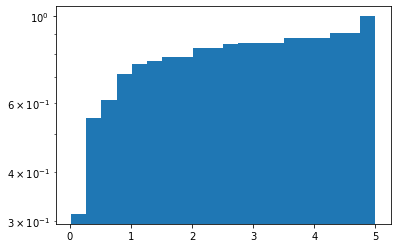

galaxies favoring MOND:  [('ESO079-G014', 0.017618369125015184, 0.6025195716692133), ('F583-4', 0.05438001998003778, 0.339586612137192), ('NGC0024', 0.07187330932845279, 1.1983363103143958), ('NGC0247', 0.01671778670489584, 0.535743199862809), ('NGC2403', 0.003165775567050726, 0.640594139396351), ('NGC2998', 0.011642328401604764, 0.4079041608283676), ('NGC3521', 0.014074033110449092, 0.5303240693378216), ('NGC3893', 0.029712512449951264, 0.520208674099393), ('NGC3949', 0.03090598425369986, 0.41516157059676345), ('NGC3972', 0.03928642707558184, 0.5689431572789296), ('NGC5585', 0.011602144582511057, 0.29037722163971097), ('NGC6503', 0.0067499308503073206, 0.4901014741361194), ('NGC7793', 0.0267727655652694, 0.4593874535015588), ('UGC00891', 0.015101971959628173, 0.1086991316904355), ('UGC05414', 0.043033218834524774, 0.159866612843551), ('UGC05764', 0.11477690176873376, 3.4048413585575625), ('UGC06917', 0.04290337259710836, 0.5714205179531995), ('UGC07089', 0.03048964182238206, 0.1396481

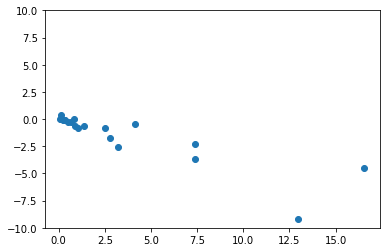

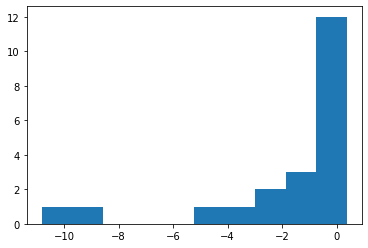

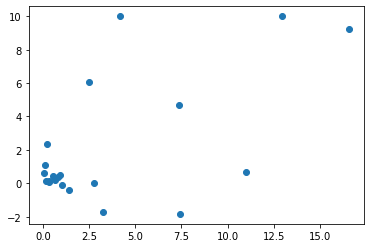

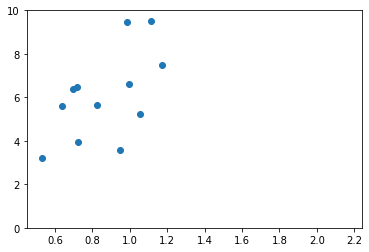

In [112]:
remove_not_common_and_sort([dic_sidm1p,pd_sidm1p],[dic_mond,pd_mond])
print(len(dic_sidm1p),len(dic_mond))
remove_not_common_and_sort([dic,pd],[dic_mond,pd_mond])
print(len(dic_sidm1p),len(dic_mond),len(dic))

l = np.array([float(item[1]) for item in like])
ls1 = np.array([float(item[1]) for item in like_sidm1p])
lm = np.array([float(item[1]) for item in like_mond])
k = np.array([float(item[1]) for item in dof])
y = np.array([float(item[1]) for item in dic_mond])
y = np.array([float(item[1]) for item in dic_mond])
x = np.array([float(item[1]) for item in dic])
z = y-x # mond - sidm, and positive values favor sidm 
z = [min(item,10) for item in z]
z = [max(item,-10) for item in z]
print("galaxies with strong evidence in favor of MOND: ",len([item for item in z if item <= -6])/len(z))
print("galaxies with positive evidence in favor of MOND: ",len([item for item in z if item < -2])/len(z))
print("galaxies with positive evidence in favor of SIDM: ",len([item for item in z if item > 2])/len(z))
print("galaxies with strong evidence in favor of SIDM: ",len([item for item in z if item >= 6])/len(z))
plt.hist([min(item,5) for item in l],cumulative=True,density=True,log=True,bins=20)
plt.show()

print("galaxies favoring MOND: ",[(l1[0],l1[2],l1[3]) for l1,db in zip(pd_mond,z) if db <= -6])
qs = np.array([l1 for l1,db in zip(l,z) if db <= -6])
qs1 = np.array([l1 for l1,db in zip(ls1,z) if db <= -6])
qm = np.array([l1 for l1,db in zip(lm,z) if db <= -6])
plt.plot(qm,qs-qm,'o')
plt.ylim([-10,10])
plt.show()
plt.hist(qs-qm)
plt.show()
plt.plot(qm,[max(min(10,x),-10) for x in qs1-qm],'o')
plt.show()
plt.plot([l1[1] for l1,db in zip(pd_mond,z) if db <= -6],[min(l1[1],15) for l1,db in zip(pd0,z) if db <= -6],'o')
plt.ylim([0,10])
plt.show()

In [ ]:
s=np.array(slope)
plt.plot(s[:,6],s[:,3],'o')
mm = np.logspace(10,15)
ms = np.array([am(item,alpha=-1.3) for item in mm])
plt.plot(mm,ms,'-')
plt.plot(mm,ms*10**0.4,'-')
plt.plot(mm,ms*10**-0.4,'-')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
from mpl_toolkits import mplot3d

# mstar/(np.pi*galaxy.Rdisk**2),slope_val,mldisk,mstar,galaxy.Rdisk,vmax
fig = plt.figure()
ax = plt.axes(projection='3d')
s = np.array(slope)
xdata = np.log10(s[:,0])
ydata = s[:,1]
zdata = np.array([min(200,item) for item in s[:,5]])
wdata = zdata
ax.scatter3D(xdata, ydata, zdata, c=wdata, cmap='viridis');
plt.show()

plt.scatter(xdata*zdata**0.5,ydata,c=zdata,marker='o')
plt.show()

In [ ]:
reduced_data_c = add_value(reduced_data)
del reduced_data

In [ ]:
j=0
for i, item in enumerate(reduced_data_c):
    outl = (np.median(np.log10(item.newvar))/0.11,np.std(np.log10(item.newvar))/0.11)
    if (np.abs(outl[0]) > 2): 
        j=j+1
        print(i,item.Q,item.Inc,item.Galaxy,item.Vflat,outl)
print(j, i)

In [ ]:
import csv

with open('sparc-vrot-sig3_ak-mldisk_nocut.csv', 'w', newline='') as csvfile:
    csv_out = csv.writer(csvfile, quotechar='#', dialect='excel')
    csv_out.writerow(['#col 1 = name'])
    csv_out.writerow(['#col 2 = N = number of data points'])
    csv_out.writerow(['#col 3 to 2+N = radii where rotation curve is measured'])
    csv_out.writerow(['#col 3+N to 2+2N = Best_fit baryon contribution to rotation curve at N radii'])
    csv_out.writerow(['#col 3+2N to 2+3N = Best_fit model rotation speed at N radii'])
    csv_out.writerow(['#col 3+3N to 2+4N = Measured rotation speed at N radii'])
    csv_out.writerow(['#col 3+4N to 2+5N = Error in measured rotation speed at N radii'])
    for item in reduced_data_c:
        n=len(item.Data.R)
        a=np.array((item.Data.R,item.min_red_chisq_v_sm[:n],\
               item.min_red_chisq_v_m[:n],item.Data.V,item.Data.e_V),\
                   dtype=(float)).flatten()
        row=[]
        row.append(item.Galaxy)
        row.append(n)
        [row.append(x) for x in a]
        csv_out.writerow(row)

In [ ]:
nva=np.array([len(item.Data.R)-(3 if sum(item.Data.Bulge) == 0 else 4) for item in reduced_data_c])
x = np.array([np.amin(item.emcee.chisq) for item in reduced_data_c])/nva
y = reduced_data_c.min_red_chisq
plt.plot(x,y,'o')
plt.plot([0.1,10],[0.1,10],'-',c='r')
plt.plot([0.1,10],[2,2],'-',c='r')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.1,10])
plt.ylim([0.1,10])
plt.show()

# x = np.median(reduced_data_c.newvar,axis=1)
# y = np.median(reduced_data_c.emcee.ml_disk,axis=1)
x1 = reduced_data_c.newvar.flatten()
y1 = reduced_data_c.emcee.ml_disk.flatten()
z1 = reduced_data_c.emcee.chisq.flatten()
x = [a for (a,b) in zip(x1,z1) if b<1]
y = [max(a,0.1) for (a,b) in zip(y1,z1) if b<1]
plt.plot(x,y,'o')
plt.xscale('log')
plt.yscale('log')
# plt.xlim([0.1,10])
# plt.ylim([0.1,10])
plt.show()


x = reduced_data_c.min_red_chisq_a_sm.flatten()
y = reduced_data_c.min_red_chisq_a_m.flatten()
plt.plot(x,y,'_')
plt.xscale('log')
plt.yscale('log')
# plt.xlim([0.1,10])
# plt.ylim([0.1,10])
plt.show()

In [ ]:
fig = plt.figure(figsize=(15,30))
nplots = 8
ax = fig.add_subplot(nplots*100 + 11)
ax1 = fig.add_subplot(nplots*100 + 12)
ax2 = fig.add_subplot(nplots*100 + 13)
ax3 = fig.add_subplot(nplots*100 + 14)
ax4 = fig.add_subplot(nplots*100 + 15)
ax5 = fig.add_subplot(nplots*100 + 16)
ax6 = fig.add_subplot(nplots*100 + 17)
ax7 = fig.add_subplot(nplots*100 + 18)

def include(item):
    return sum(item.Data.Bulge) > -1 and item.min_red_chisq < 1000000
x_arr = []
y_arr = []
v_arr = []
r_arr = []
mb_arr = []
for item, item_c in zip(reduced_data,reduced_data_c):
    if include(item):
        if contours(np.log10(item.emcee.vmax), np.log10(item.emcee.rmax), item.red_chisq, 1, np.log10(350.0), ax) < 0: print(item.Galaxy)
#     if include(item_c):
#         if contours(np.log10(item_c.emcee.vmax), np.log10(item_c.emcee.rmax), item_c.red_chisq, 1, np.log10(350.0), ax1) < 0: print(item_c.Galaxy)

#         nv = np.ma.masked_outside(np.log10(item.newvar), -1, 1)
    vv = np.ma.masked_outside(np.log10(item.emcee.vmax), 1, np.log10(350.0))
    mask = vv.mask
#         mask = np.ma.mask_or(nv.mask, vv.mask)
    vv = np.ma.compressed(np.ma.array(np.log10(item.emcee.vmax), mask = mask))
    ss = np.ma.compressed(np.ma.array(np.log10(item.emcee.sigma0), mask = mask))
    cc = np.ma.compressed(np.ma.array(np.log10(item.emcee.cross), mask = mask))
    rr = np.ma.compressed(np.ma.array(np.log10(item.emcee.rmax), mask = mask))
    mb = np.ma.compressed(np.ma.array(np.log10(item.m_baryons), mask = mask))
    if len(cc) > 0: 
        vl,vm,vh = np.percentile(vv, [32, 50, 68],axis=0)
        ve = (vh-vl)/2.0
        cl,cm,ch = np.percentile(cc, [32, 50, 68],axis=0)
        ce = (ch-cl)/2.0
#         if include(item): ax2.errorbar(vm, cm, xerr = ve, yerr= ce, fmt='--o')
        x_arr.append([vm,ve])
        y_arr.append([cm,ce])
    if len(rr) > 0: 
        vl,vm,vh = np.percentile(vv, [32, 50, 68],axis=0)
        ve = (vh-vl)/2.0
        rl,rm,rh = np.percentile(rr, [32, 50, 68],axis=0)
        re = (rh-rl)/2.0
        if include(item): ax3.errorbar(vm, rm, xerr = ve, yerr= re, fmt='--o')
    if len(mb) > 0: 
        vl,vm,vh = np.percentile(vv, [32, 50, 68],axis=0)
        ve = (vh-vl)/2.0
        ml,mm,mh = np.percentile(mb, [32, 50, 68],axis=0)
        me = (mh-ml)/2.0
        if include(item): ax5.errorbar(vm, mm, xerr = ve, yerr= me, fmt='--o')
    if len(ss) > 0:
        vl,vm,vh = np.percentile(vv, [32, 50, 68],axis=0)
        ve = (vh-vl)/2.0
        sl,sm,sh = np.percentile(ss, [32, 50, 68],axis=0)
        se = (sh-sl)/2.0
        if include(item): ax7.errorbar(vm, sm, xerr = ve, yerr= se, fmt='o', ecolor='b')

#     vv1 = np.ma.masked_invalid(np.log10(item.v_max))
#     vv2 = np.ma.masked_outside(np.log10(item.v_max), 1, np.log10(350.0))
#     mask = np.ma.mask_or(vv1.mask, vv2.mask)
#     vv = np.ma.compressed(np.ma.array(np.log10(item.v_max), mask = mask))
#     rr = np.ma.compressed(np.ma.array(np.log10(item.r_max), mask = mask))
#     if len(rr) > 0: 
#         vl,vm,vh = np.percentile(vv, [32, 50, 68],axis=0)
#         ve = (vh-vl)/2.0
#         rl,rm,rh = np.percentile(rr, [32, 50, 68],axis=0)
#         re = (rh-rl)/2.0
#         if include(item): ax4.errorbar(vm, rm, xerr = ve, yerr= re, fmt='--o')

    vv = np.ma.masked_outside(np.log10(item_c.emcee.vmax), 1, np.log10(350.0))
    mask = vv.mask
    vv = np.ma.compressed(np.ma.array(np.log10(item_c.emcee.vmax), mask = mask))
    ss = np.ma.compressed(np.ma.array(np.log10(item_c.emcee.sigma0), mask = mask))
    cc = np.ma.compressed(np.ma.array(np.log10(item_c.emcee.cross), mask = mask))
    rr = np.ma.compressed(np.ma.array(np.log10(item_c.emcee.rmax), mask = mask))
    mb = np.ma.compressed(np.ma.array(np.log10(item_c.m_baryons), mask = mask))
    md = np.ma.compressed(np.ma.array(np.log10(item_c.m_star), mask = mask))
    if len(cc) > 0: 
        vl,vm,vh = np.percentile(vv, [32, 50, 68],axis=0)
        ve = (vh-vl)/2.0
        cl,cm,ch = np.percentile(cc, [32, 50, 68],axis=0)
        ce = (ch-cl)/2.0
        if include(item): ax2.errorbar(vm, cm, xerr = ve, yerr= ce, fmt='--o')    
    if len(rr) > 0: 
        vl,vm,vh = np.percentile(vv, [32, 50, 68],axis=0)
        ve = (vh-vl)/2.0
        rl,rm,rh = np.percentile(rr, [32, 50, 68],axis=0)
        re = (rh-rl)/2.0
        if include(item_c): ax4.errorbar(vm, rm, xerr = ve, yerr= re, fmt='--o')
        v_arr.append([vm,ve])
        r_arr.append([rm,re])
    if len(mb) > 0: 
        vl,vm,vh = np.percentile(vv, [32, 50, 68],axis=0)
        ve = (vh-vl)/2.0
        ml,mm,mh = np.percentile(md, [32, 50, 68],axis=0)
        me = (mh-ml)/2.0
        vm = np.log10(item_c.Vflat)
        ve = 0
        if include(item_c): ax6.errorbar(vm, mm, xerr = ve, yerr= me, fmt='--o')
    if len(ss) > 0:
        vl,vm,vh = np.percentile(vv, [32, 50, 68],axis=0)
        ve = (vh-vl)/2.0
        sl,sm,sh = np.percentile(ss, [32, 50, 68],axis=0)
        se = (sh-sl)/2.0
        if include(item_c): ax7.errorbar(vm, sm, xerr = ve, yerr= se, fmt='o', ecolor='r')

# ax.set_ylim([1,500])
ax.set_xlim([1.3,2.7])
ax.set_xlabel(r'$V_{\rm max}$')
ax.set_ylabel(r'$R_{\rm max}$')
ax1.set_xlim([1.3,2.7])
ax1.set_xlabel(r'$V_{\rm max}$')
ax1.set_ylabel(r'$R_{\rm max}$')
ax2.set_xlim([1.6,2.7])
ax2.set_ylim([-2,1])
ax2.set_xlabel(r'$V_{\rm max}$')
ax2.set_ylabel(r'$\sigma/m$')
# ax3.set_xlim([-1,1])
# ax3.set_ylim([-2,1])
ax3.set_xlim([1.3,2.7])
ax3.set_ylim([0.5,3])
ax3.set_xlabel(r'$V_{\rm max}$')
ax3.set_ylabel(r'$R_{\rm max}$')
ax4.set_xlim([1.3,2.7])
ax4.set_ylim([0.5,3])
ax4.set_xlabel(r'$V_{\rm max}$')
ax4.set_ylabel(r'$R_{\rm max}$')

v1 = np.linspace(1,2.8,10)
r1 = 1.4*(v1 - np.log10(1e2)) + np.log10(3e1)
m1 = np.log10(50.0) + 4.0*v1
r0 = r1 - 0.2
r2 = r1 + 0.2
m0 = m1 - 0.2
m2 = m1 + 0.2

ax.plot(v1, r1, 'r-')
ax.plot(v1, r0, 'r-')
ax.plot(v1, r2, 'r-')

ax1.plot(v1, r1, 'r-')
ax1.plot(v1, r0, 'r-')
ax1.plot(v1, r2, 'r-')

ax3.plot(v1, r1, 'g-')
ax3.plot(v1, r0, 'g-')
ax3.plot(v1, r2, 'g-')

ax4.plot(v1, r1, 'g-')
ax4.plot(v1, r0, 'g-')
ax4.plot(v1, r2, 'g-')

ax5.plot(v1, m1, 'g-')
ax5.plot(v1, m0, 'g-')
ax5.plot(v1, m2, 'g-')

ax6.plot(v1, m1, 'g-')
ax6.plot(v1, m0, 'g-')
ax6.plot(v1, m2, 'g-')

ax7.plot(v1, v1-0.5*np.log10(3), 'g-')
ax7.plot(v1, v1-0.5*np.log10(2), 'g-')

fig.show()
fig.savefig('vmax-rmax-cross.pdf')

x_arr = np.array(x_arr)
y_arr = np.array(y_arr)
v_arr = np.array(v_arr)
r_arr = np.array(r_arr)

In [ ]:
prior_in = [(-2,1),(-0.01,0.01)]
p, samples = estimate_fit(x_arr[:,0], y_arr[:,0], x_arr[:,1], y_arr[:,1], prior_in)
print(p)

In [ ]:
x = []
y = []
c = []
v = []
r = []
z = np.zeros(len(reduced_data_c))
for i, item in enumerate(reduced_data_c):
    ch = item.red_chisq
    ch_min = item.min_red_chisq
    ch_c = min(np.percentile(ch, 68, axis=0), ch_min+2.3)
    for x_v,y_v,ch_v,r1,v_v,r_v in zip(item.emcee.cross,item.newvar,ch,item.emcee.r1,item.emcee.vmax,item.emcee.rmax):
        if ch_v < ch_c and v_v < 350: 
#         if ch_v < ch_c and item.Data.R[0]<r1<item.Data.R[-1]: 
            x.append(x_v)
            y.append(y_v)
            v.append(v_v)
            r.append(r_v)
            z[i]+=1
            
z /= len(reduced_data_c[0].emcee.rho0)
print(len(x),len(reduced_data_c[0].emcee.rho0)*len(reduced_data_c))

len([item for item in z if item < 0.01])

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(211)
v1 = np.logspace(1,3,10)
r1 = 30*(v1/100)**1.3
r0 = 30*(v1/100)**1.3 / 10**0.3
r2 = 30*(v1/100)**1.3 * 10**0.3
ax.scatter(v, r, s = 0.1)
ax.scatter(v1, r1, c='r')
ax.scatter(v1, r0, c='b')
ax.scatter(v1, r2, c='b')
ax.set_xscale('log')
ax.set_yscale('log')

ax = fig.add_subplot(212)
H, xedges, yedges = np.histogram2d(np.log10(v), np.log10(r),  bins=[15,15])
xcenters = xedges[:-1] + 0.5 * (xedges[1:] - xedges[:-1])
ycenters = yedges[:-1] + 0.5 * (yedges[1:] - yedges[:-1])
cs = plt.contourf(xcenters, ycenters, H)
plt.colorbar(cs)
fig.show()

In [ ]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *

init_notebook_mode(connected=True) # run at the start of every ipython notebook to use plotly.offline
                     # this injects the plotly.js source files into the notebook

In [ ]:
data = [
    Histogram(
        x=np.log10(y)-np.log10(1.2)
    )
]
iplot(data, show_link=False)


In [ ]:
iplot([
Histogram2dContour(x=np.log10(v), y=np.log10(r))], show_link=False)

In [ ]:
import numpy as np
import numdifftools.nd_algopy as nda
import emcee
from numpy.random import uniform
from numpy.random import rand
from numpy.random import normal
import scipy.optimize as op
import corner
import timeit

def fit_fun(x, theta):
    return theta[0] + theta[1] * (x/1e2)

def dydx(x, theta):
    return theta[1] 

def starting_values(estimate, prior, fraction):
    return [ uniform( low = val - fraction * (val - pri[0]), high = val + fraction * (pri[1] - val) )\
            for val, pri in zip(estimate,prior) ]

def estimate_fit(x, y, xerr, yerr, prior_in):

    nparam = len(prior_in)
    ndata = len(y)

    x = np.array(x); y = np.array(y); xerr = np.array(xerr); yerr = np.array(yerr);
    
    prior = np.array(list(prior_in)+[(min(y),max(y)),(0,max(y)-min(y))]+[(0.5,1)])
    print(prior)
    
#     def yf(a): return fit_fun(a[0],a[1:])
#     grad_yf = nda.Gradient(yf)
#     def dydx(x,theta1):
#         return list(map((lambda s: grad_yf([s]+list(theta1))[0]),x))
    
    def lnlike(theta):
        theta1 = theta[:nparam]
        mub = theta[nparam]
        Vb = theta[nparam+1]
        err2 = yerr ** 2 + ( dydx(x, theta1) * xerr ) ** 2
        errb2 = err2 + Vb ** 2
        p = theta[-1]
        model = fit_fun(x, theta1)
        s = -0.5 * ( y - model ) ** 2 / err2 + np.log( p / np.sqrt( 2.0 * np.pi * err2 ) )
        b = -0.5 * ( y - mub ) ** 2 / errb2 + np.log( ( 1 - p ) / np.sqrt( 2.0 * np.pi * errb2 ) )
        return np.sum( [ np.logaddexp(sv, bv) for sv,bv in zip(s,b) ] )
    
    def lnprior(theta):
        if np.all([item[1][0] <= item[0] <= item[1][1] for item in zip(theta,prior)]):
            return 0.0
        return -np.inf

    def lnprob(theta):
        lp = lnprior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + lnlike(theta)

#     estimate = np.array([0,0,np.mean(y),np.std(y),0.9])
    estimate = np.concatenate((np.mean(prior_in,axis=1),[np.mean(y),np.std(y),0.99]))
    print("starting estimate and lnprob : ", estimate, lnprob(estimate))
        
    print([item[1][0] <= item[0] <= item[1][1] for item in zip(estimate,prior)])
    nll = lambda *args: -lnlike(np.concatenate((*args,estimate[nparam:])))
    result = op.minimize(nll, estimate[:nparam], method='SLSQP', bounds=prior[:nparam])
    estimate = np.concatenate((result["x"], estimate[nparam:]))
#     nll = lambda *args: -lnlike(*args)
#     result = op.minimize(nll, estimate, method='SLSQP', bounds=prior)
#     estimate = result["x"]

    print("optimized estimate and lnprob : ",estimate, lnprob(estimate))
    
    ndim = len(prior)
    nwalkers, nburn, niter = 10 * ndim, 100 * ndim, 1000 * ndim
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
    pos0 = np.array( [ starting_values(estimate, prior, 0.1) for i in range(nwalkers) ] )
    print("Starting walkers with lnprob values: ")
    print(list(map(lnlike,pos0)))
    assert pos0.shape == (nwalkers, ndim)
    for pos, lnprob0, lnlike0 in sampler.sample(pos0, iterations=nburn):
        pass
    sampler.reset()    
    sampler.run_mcmc(pos, niter)
    assert sampler.chain.shape == (nwalkers, niter, ndim)
    print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
    samples = sampler.flatchain
    p = list( map( lambda v: (v[1], v[2]-v[1], v[1]-v[0]),\
                  zip( *np.percentile(samples, [16, 50, 84],axis=0) ) ) )
    return p, samples


In [ ]:
from scipy.interpolate import InterpolatedUnivariateSpline

GNewton = 4.302113488372941e-06  # G in kpc * (km/s)**2 / Msun

massBb, massBbp, massBd, massBdp, massBg, massBgp = \
(lambda x: 0), (lambda x: 0), (lambda x: 0), (lambda x: 0), (lambda x: 0), (lambda x: 0)

def nfw_m_profile(x):
    return np.log(1+x) - x/(1.0 + x)

x = np.logspace(-4,4,num=100)
y = list(map((lambda x: nfw_m_profile(x)*(1+1/x)**2),x))
r1_over_rs = InterpolatedUnivariateSpline(y,x)

def unpack(theta):
    return 10**(theta[0]-theta[1]-theta[2])/rate_const, 10**theta[1], 10**theta[2], theta[3], theta[4]

def get_vir(rmax, vmax):
    mvir = 2.65 * (vmax**2 * rmax / 4.302e-6) * (vmax/200) ** (-0.15)
    rvir = (mvir/((4*np.pi/3) * 100.0 * 130.0)) ** 0.333333
    return rvir, mvir

def rbar(r, rv):
#     return 0.85 * (r/rv) ** 0.8 * rv
    return r

def rrbar(rbar, rv):
    # rrbar(rbar(r,rv),rv) = r
#     return ( rbar / ( 0.85 * rv ) ) ** (1.0/0.8) * rv
    return rbar

def get_r1i(ml_disk, ml_bulge, r1, m1, rho1, rmax, vmax):
    global massBb, massBbp, massBd, massBdp, massBg, massBgp
    rv, mv = get_vir(rmax, vmax)
    fB = (massBb(rv)*ml_bulge + massBd(rv)*ml_disk + massBg(rv))/mv
    rf = rrbar(r1, rv)
    mB1 = massBb(r1)*ml_bulge + massBd(r1)*ml_disk + massBg(r1)
    fB1 = mB1/(mB1+m1)
    mBp1 = massBbp(r1)*ml_bulge + massBdp(r1)*ml_disk + massBgp(r1)
    gammabf1 = r1*mBp1/mB1
    xi = (1-fB1)/(1-fB)
    ri = rf/xi
    r1i = rbar(ri, rv)
    gammadm1 = 4 * np.pi * r1 ** 3 * rho1 / m1
#     print(gammadm1, fB1, gammabf1)
    gammadm1i = gammadm1
    return r1i, gammadm1i

def get_interpolated_profile(r, v):
    lines = np.array(list(zip(r, v**2 * r / GNewton)))
    lines = np.insert(lines,0,[lines[0,0]/2,lines[0,1]/4],axis=0)
    lines = np.insert(lines,0,[0,0],axis=0)
    for r in np.logspace(np.log10(1.5*lines[-1,0]),np.log10(max(5.0*lines[-1,0],2000.0)),num=5):
        lines = np.insert(lines,len(lines),[r,1.001*lines[-1,1]],axis=0)
    mass = InterpolatedUnivariateSpline(lines[:,0], lines[:,1], k=2)
    massp = mass.derivative()
    return mass, massp

def get_massB(galaxy):
    global massBb, massBbp, massBd, massBdp, massBg, massBgp
    if np.sum(galaxy.Data.Bulge) > 0: 
        massBb, massBbp = get_interpolated_profile(galaxy.Data.R, galaxy.Data.Bulge)
    else:
        massBp, massBbp = (lambda x: 0), (lambda x: 0)
    massBd, massBdp = get_interpolated_profile(galaxy.Data.R, galaxy.Data.Disk)
    massBg, massBgp = get_interpolated_profile(galaxy.Data.R, galaxy.Data.Gas)
    return 1


def get_vmax_rmax_nfw(galaxy, ml_disk, ml_bulge, r1, m1, rho1, rmax1, vmax1):
    global massBb, massBbp, massBd, massBdp, massBg, massBgp
    get_massB(galaxy)
    r1i, gammadm1i = get_r1i(ml_disk, ml_bulge, r1, m1, rho1, rmax1, vmax1)
    rs = r1i / r1_over_rs(1.0/gammadm1i)
    rmax = 2.163 * rs
    mnfw0 = m1 / nfw_m_profile(r1i/rs)
    vmax = np.sqrt(GNewton * mnfw0 * nfw_m_profile(2.163) / rmax )
#     print(vmax1, rmax1)
    return vmax, rmax


In [ ]:
x=[]
y=[]
z=[]
for item in reduced_data_c:
    if item.Data.R[0] < 2:
        x.append(item.Regr.V[2])
        y.append(item.Regr.Vdm_med(2)/item.Regr.V[2])
        z.append(item.Regr.Vdm_min(2)/item.Regr.V[2])
plt.plot(x,y,'o',c='b')
plt.plot(x,z,'o',c='r')
plt.ylim([0,1])

In [ ]:
for item in reduced_data_c:
    if item.Data.R[0] < 2:
        if item.Regr.V[2] > 120 and item.Regr.Vdm_med(2)/item.Regr.V[2] > 0.8: 
            print(item.Galaxy, item.Regr.V[2], item.Regr.Vdm_min(2), np.median(item.newvar), np.median(item.emcee.cross))


In [ ]:
for i, item in enumerate(reduced_data):
    if np.median(item.emcee.vmax) > 200 and np.median(item.newvar) > 10**0.2 and item.min_red_chisq < 20: 
        print(i, item.Galaxy, item.Vflat, item.min_red_chisq, np.std(item.red_chisq), np.median(item.emcee.vmax), np.std(item.emcee.vmax), 
               np.median(np.log10(item.newvar)), np.median(item.emcee.ml_disk))

In [ ]:
x = reduced_data[85].red_chisq
y = reduced_data[85].emcee.cross
plt.plot(x,y,'o')

In [ ]:
from glob import glob
glob('/Users/mkapling/Dropbox/ipynb/Rotation curves/*.py')+glob('/Users/mkapling/Dropbox/ipynb/Rotation curves/*.ipynb')

In [ ]:
l1=[]
l2=[]
for galaxy in reduced_data:
    nd = len(galaxy.Data.R)
    a1 = [(c+0*np.log(nd))/(nd-3) for c,m1 in \
        zip(galaxy.emcee.chisq,galaxy.emcee.ml_disk) \
            if 0.3<m1<0.8]
    if len(a1) > 0:
        v1= np.min(a1)
        l1.append(v1)
        v2 = np.min([(c+0*np.log(nd))/(nd-3) for c in galaxy.emcee.chisq])
        l2.append(v2)

In [ ]:
plt.hist(l2,log=True,density=True,cumulative=True,color='r',bins=15,range=(0,3))
plt.hist(l1,log=True,density=True,cumulative=True,color='b',bins=15,range=(0,3))
plt.show()
print(len(l1))

plt.hist([np.median(galaxy.emcee.ml_bulge) for galaxy in reduced_data \
          if sum(galaxy.Data.Bulge)>0],\
        color='r')

In [ ]:
reduced_data_mond = pickle.load( open(os.path.join(saved_here,'sparc_mond_a012.txt'),"rb") )
reduced_data_mond = reduced_data_mond.view(np.recarray)
print(reduced_data_mond.dtype)

In [ ]:
import numpy as np
la=[]
la2=[]
for galaxy in reduced_data:
    nd = len(galaxy.Data.R)
    npar = 4 if sum(galaxy.Data.Bulge) > 0 else 3
    v1 = min([(c+2*npar)/(nd-npar) for c in galaxy.emcee.chisq])
    v1 = min(v1,10)
    la.append(v1)
    v1 = min([(c+npar*np.log(nd))/(nd-npar) for c in galaxy.emcee.chisq])
    v1 = min(v1,10)
    la2.append(v1)
lm=[]
lm2=[]
for galaxy in reduced_data_mond:
    nd = len(galaxy.Data.R)
    npar = 2 if sum(galaxy.Data.Bulge) > 0 else 1
    v1 = min([(c+2*npar)/(nd-npar) for c in galaxy.emcee.chisq])
    v1 = min(v1,10)
    lm.append(v1)
    v1 = min([(c+npar*np.log(nd))/(nd-npar) for c in galaxy.emcee.chisq])
    v1 = min(v1,10)
    lm2.append(v1)

print(len(la))
print(len(lm))

plt.hist(la,log=False,density=True,cumulative=True,color='r',bins=20)
plt.hist(lm,log=False,density=True,cumulative=True,color='b',bins=20)
plt.show()

plt.hist(la2,log=False,density=True,cumulative=True,color='r',bins=20)
plt.hist(lm2,log=False,density=True,cumulative=True,color='b',bins=20)
plt.show()

In [ ]:
plt.scatter(la,lm)
plt.plot([0,10],[0,10],'r-')
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.scatter(la2,lm2)
plt.plot([0,10],[0,10],'r-')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
for galaxy in reduced_data:
    rr=np.median(galaxy.emcee.rvir)
    plt.plot(rr*0.015,rr*0.015,'-')
    plt.plot(rr*0.015,np.min(galaxy.Data.R),'o')
    plt.plot(rr*0.015,np.max(galaxy.Data.R),'o')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
for galaxy in reduced_data:
    rr=np.median(galaxy.emcee.rvir)*0.015
    drr=np.std(galaxy.emcee.rvir)*0.015
    if np.min(galaxy.Data.R) < rr < np.max(galaxy.Data.R): 
        continue
    else:
        print(galaxy.Galaxy,np.min(galaxy.Data.R),rr,np.max(galaxy.Data.R),drr)


In [ ]:
def unpickle_nfw(loc, sdir = None):
    if sdir: 
        fod = os.path.join(sdir,loc)
    else:
        fod = os.path.join(os.getcwd(),loc)
    if os.path.isfile(fod):
        reduced_data = pickle.load( open(fod,"rb") )
        reduced_data = reduced_data.view(np.recarray)
    else:
        files = [os.path.join(fod, f) for f in os.listdir(fod) if os.path.isfile(os.path.join(fod, f))]
        reduced_data = pickle.load( open(files[0],"rb") )
        for file in files[1:]:
            a = pickle.load( open(file,"rb") )
            reduced_data = stack_arrays((reduced_data,a), usemask=False, asrecarray=True)       
    return reduced_data
reduced_data_nfw = unpickle_nfw('sparc_cross_3_reg_sqrt2_c200g_rate_1e5_ac.txt', sdir = saved_here)

In [ ]:
mldisk = [np.median(galaxy.emcee.ml_disk) for galaxy in reduced_data_nfw]
c200 = [np.median(galaxy.emcee.cvir) for galaxy in reduced_data_nfw]
m200 = [np.median(galaxy.emcee.mvir) for galaxy in reduced_data_nfw]
chisqmin_all = []
chisqmin = []
for galaxy in reduced_data_nfw:
    cc = [c for c,l in zip(galaxy.emcee.chisq,galaxy.emcee.ml_disk) if 0.3<l<0.8]
    if len(cc)>0:
        chisqmin.append(min(5,np.min(cc)/(len(galaxy.Data.R)-4)))
        chisqmin_all.append(min(np.min(galaxy.emcee.chisq)/(len(galaxy.Data.R)-4),5))
plt.hist(mldisk,bins=15)
plt.show()
plt.hist(chisqmin_all,cumulative=True,density=True,log=True,color='b')
plt.hist(chisqmin,cumulative=True,density=True,log=True,color='r')
plt.show()

In [ ]:
plt.plot(m200,c200,'o')
plt.xscale('log')
plt.yscale('log')
mm = np.logspace(9,13,5)
cc0 = 10*(mm/1e12)**-0.09
cc1 = 10*(mm/1e12)**-0.09 * 10**0.22
cc2 = 10*(mm/1e12)**-0.09 * 10**-0.22
plt.plot(mm,cc0)
plt.plot(mm,cc1)
plt.plot(mm,cc2)
plt.show()

In [ ]:
ll = [min(np.min(g.emcee.chisq)/(len(g.Data.R)-1),10) for g in reduced_data]
plt.hist(ll,cumulative=True,density=True)

In [ ]:
import sys
sys.path.append('C:/Users/kapli/Dropbox/Workdocs/Python/Cosmology')
from cosmo.abundance_matching import abundance_match_behroozi_2012 as am
mh = np.logspace(9,13,10)
mhh = [np.median(g.emcee.mvir) for g in reduced_data]
mss = [g.Lum*np.median(g.emcee.ml_disk)*1e9 for g in reduced_data]
ms = [am(m) for m in mh]
ms2 = [am(m,alpha=-1.9) for m in mh]
plt.scatter(mh,ms)
plt.scatter(mh,ms2,c='red')
plt.scatter(mhh,mss,c='black')
plt.xscale('log')
plt.yscale('log')

In [ ]:
plt.scatter(mss,ll)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
asm = np.ravel([[tuple(vsm**2/g.Data.R) for vsm in g.emcee.v_sm] for g in reduced_data])
atot = np.ravel([[tuple(vm**2/g.Data.R) for vm in g.emcee.v_m] for g in reduced_data])

In [ ]:
asm1=[]
atot1=[]
for a in asm:
    for a1 in a:
        asm1.append(a1)
for a in atot:
    for a1 in a:
        atot1.append(a1)

In [ ]:
plt.scatter(asm1,atot1)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
for a1,a2 in zip(asm[::5],atot[::5]):
    plt.plot(a1,a2)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
mll = [np.median(g.emcee.ml_disk) for g in reduced_data if len(g.Data.R)>4]
mllmond = [np.median(g.emcee.ml_disk) for g in reduced_data_mond if np.sum(g.Data.Bulge)==0]
print(len(mllmond),len(mll))
plt.hist(mllmond,density=True,bins=15)
plt.hist(mll,density=True,bins=10)
plt.show()
print(np.median(np.ravel([g.emcee.ml_disk for g in reduced_data])))

In [ ]:
dset_sidm = add_value(reduced_data[[len(g.Data.R)>4 for g in reduced_data]], nhalo_params=0)
dset_mond = add_value(
    reduced_data_mond[[not np.sum(g.Data.Bulge) > 0 for g in reduced_data_mond]], nhalo_params=0)

In [ ]:
plt.hist([g.min_red_chisq_params[3] for g in dset_sidm])
plt.hist([g.min_red_chisq_params[1] for g in dset_mond])
plt.show()

In [ ]:
const = 1e3/3.08e16
for g in dset_sidm:
    ndata = len(g.Data.R)
    plt.plot(g.min_red_chisq_a_sm[:ndata]*const,g.min_red_chisq_a_m[:ndata]*const)
plt.xscale('log')
plt.yscale('log')

In [ ]:
out1 = []
for gs,gm in zip(dset_sidm,dset_mond):
    out1.append((gs.Galaxy,gs.min_red_chisq,gs.min_red_chisq_params[3],\
               gm.Galaxy,gm.min_red_chisq,gm.min_red_chisq_params[1]))
out1 = np.array(out1)
np.savetxt('sidm_1p.csv', out1, delimiter=',', fmt="%20s")

In [ ]:
const = 1e3/3.08e16
for gs,gm in zip(dset_sidm,dset_mond):
    ndata = len(gs.Data.R)
    if not gs.Galaxy == gm.Galaxy: print('what')
    out1 = list(zip(gs.min_red_chisq_a_sm[:ndata]*const,gs.min_red_chisq_a_m[:ndata]*const,\
                    gm.min_red_chisq_a_sm[:ndata]*const,gm.min_red_chisq_a_m[:ndata]*const))
    out1 = np.array(out1)
    fname = gs.Galaxy+'_asm_am.txt'
    np.savetxt('sidm_1p_comparison/'+fname, out1, delimiter=',', fmt="%20s")

In [ ]:
ll = [min(g.min_red_chisq,10) for g in dset_sidm]
mll = [min(g.min_red_chisq,10) for g in dset_mond]
plt.hist(ll,cumulative=True,density=True)
plt.hist(mll,cumulative=True,density=True)
plt.show()

In [ ]:
const = 1e3/3.08e16
acc  = []
for gs,gm in zip(dset_sidm,dset_mond):
    ndata = len(gs.Data.R)
    for g1,g2 in zip(gs.min_red_chisq_a_sm[:ndata]*const,gs.min_red_chisq_a_m[:ndata]*const):
        acc.append([g1,g2])
acc = np.array(acc)
ab = np.logspace(-13,-8.5,40)
acc = np.sort(acc,axis=0)
at = np.zeros_like(ab)
n = np.zeros_like(ab)
for a,b in acc:
    i = np.searchsorted(ab,a)
    if i==40: print(at[i-1],a)
    at[i]+=b
    n[i]+=1
print(n)
for i in range(len(at)):
    at[i]/=n[i]
plt.plot(ab[4:-3],at[4:-3])
print(ab[4:-3])
plt.yscale('log')
plt.xscale('log')